
# Projeto Integrado — Deep Learning

Integrantes:  
Arthur  
358843  
Eduardo  
359302  
Gustavo  
358496  
Wagner   
360191

# O QUE É ESPERADO COMO ENTREGA? 
A solução implementada utilizando modelos de Deep Learning com Tensorflow para as   
4 ações e outras soluções diferenciadas e inovadores (opcional) que possam ser   
aplicadas ao conjunto de dados proposto.  
 • Devem ser entregues em formato de Jupyter Notebook;  
 As quatro ações devem ter modelos treinados, e devem ser apresentados os seguintes 
indicadores:  
 • Acurácia no conjunto de teste  de cada modelo;  
 • Matriz de confusão, precision e recall de cada modelo;  
 • Desempenho financeiro do modelo via ‘backtest’ com o objetivo de responder se o 
modelo gerado   
daria retorno financeiro (opcional pois é um assunto de finanças, se 
não fizer não há prejuízo na nota final);

In [1]:

# ================== SETUP & CONFIG ==================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from IPython.display import display, Markdown

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

CONFIG = {
    'DATA_DIR': Path('bases'),
    'FILES': {
        'VALE3': {'train': 'VALE3SA/treino.csv', 'test': 'VALE3SA/teste.csv'},
        'PETR4': {'train': 'PETR4SA/treino.csv', 'test': 'PETR4SA/teste.csv'},
        'BBAS3': {'train': 'BBAS3SA/treino.csv', 'test': 'BBAS3SA/teste.csv'},
        'CSNA3': {'train': 'CSNA3SA/treino.csv', 'test': 'CSNA3SA/teste.csv'},
    },
    'LABEL_COL': 'Label',
    'DATE_COL': 'Date',
    'CLOSE_COL': 'Close',
    'WINDOW': 15,
}

LAG_COLS = [f"Past_{i}_Days_Close" for i in range(1, CONFIG['WINDOW']+1)]


In [2]:

# ================== FUNÇÕES ==================
def load_pair(ticker: str):
    base = CONFIG['DATA_DIR']
    train_rel = CONFIG['FILES'][ticker]['train']
    test_rel  = CONFIG['FILES'][ticker]['test']
    df_tr = pd.read_csv(base / train_rel)
    df_te = pd.read_csv(base / test_rel)
    return df_tr, df_te

def parse_dates_inplace(df: pd.DataFrame):
    dc = CONFIG['DATE_COL']
    if dc in df.columns:
        df[dc] = pd.to_datetime(df[dc], errors='coerce')

def prepare_xy(df: pd.DataFrame):
    X = df[LAG_COLS].astype(float).values
    y = df[CONFIG['LABEL_COL']].astype(int).values
  
    uniq = sorted(pd.unique(y))
    
    return X, y

def scale_and_reshape(Xtr, Xte):
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    Xtr_seq = Xtr_s.reshape(-1, CONFIG['WINDOW'], 1)
    Xte_seq = Xte_s.reshape(-1, CONFIG['WINDOW'], 1)
    return Xtr_s, Xte_s, Xtr_seq, Xte_seq



## EDA
Inclui:
- `head()` do treino e do teste + listagem de colunas
- dimensão e período de datas 
- distribuição de rótulos (contagem e %), **treino** e **teste**
- série temporal de `Close` (treino e teste)



# VALE3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.829122,1.752574,1,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375,1.562375,1.600482
1,2,2000-01-25,1.829122,1.760229,1,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375,1.562375
2,3,2000-01-26,1.813879,1.765594,1,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375
3,4,2000-01-27,1.829122,1.771947,1,1.813879,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375
4,5,2000-01-28,1.829122,1.777664,1,1.829122,1.813879,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4809,2019-02-26,32.196571,31.573791,1,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454
1,4810,2019-02-27,31.944181,31.610830,1,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266
2,4811,2019-02-28,32.128353,31.662583,1,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816
3,4812,2019-03-01,31.882784,31.684603,1,32.128353,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762
4,4813,2019-03-06,32.776375,31.793780,1,31.882784,32.128353,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4808, 20) / (1203, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-02-25 00:00:00  
- **Período teste:** 2019-02-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2716, 1: 2092}  
**Treino (%):** {-1: 56.49, 1: 43.51}

**Teste:** {-1: 601, 1: 602}  
**Teste (%):** {-1: 49.96, 1: 50.04}

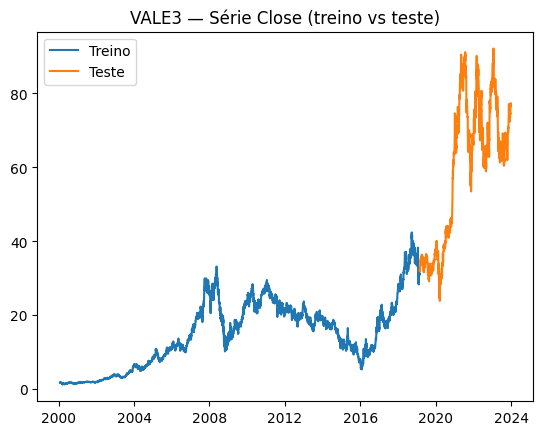

# PETR4 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.274788,1.347845,-1,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341,1.450586
1,2,2000-01-25,1.274788,1.340540,-1,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341
2,3,2000-01-26,1.290096,1.335495,-1,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514
3,4,2000-01-27,1.280960,1.330042,-1,1.290096,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823
4,5,2000-01-28,1.280960,1.325134,-1,1.280960,1.290096,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4809,2019-02-26,9.467936,9.376527,1,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832
1,4810,2019-02-27,9.646040,9.403478,1,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673
2,4811,2019-02-28,9.638913,9.427022,1,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191
3,4812,2019-03-01,9.510681,9.435388,1,9.638913,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439
4,4813,2019-03-06,9.532050,9.445054,1,9.510681,9.638913,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4808, 20) / (1203, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-02-25 00:00:00  
- **Período teste:** 2019-02-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2654, 1: 2154}  
**Treino (%):** {-1: 55.2, 1: 44.8}

**Teste:** {-1: 581, 1: 622}  
**Teste (%):** {-1: 48.3, 1: 51.7}

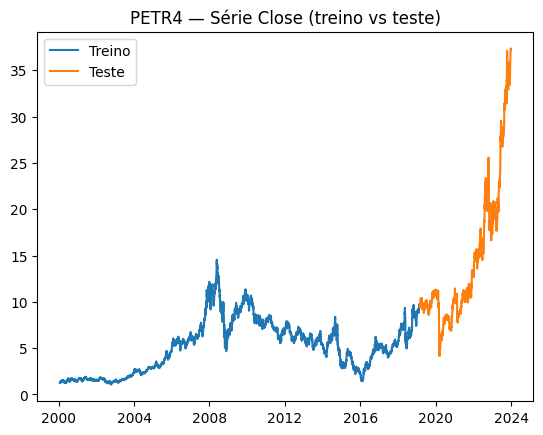

# BBAS3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.062769,1.071645,-1,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457,1.074564
1,2,2000-01-26,1.087668,1.073247,-1,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457
2,3,2000-01-27,1.064080,1.072330,-1,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940
3,4,2000-01-28,1.036561,1.068753,-1,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355
4,5,2000-01-31,1.035250,1.065403,-1,1.036561,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4736,2019-03-26,36.386158,37.917648,-1,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129
1,4737,2019-03-27,34.371300,37.563014,-1,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866
2,4738,2019-03-28,35.571316,37.363844,-1,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150
3,4739,2019-03-29,36.089863,37.236446,-1,35.571316,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489
4,4740,2019-04-01,36.445412,37.157342,-1,36.089863,35.571316,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4735, 20) / (1185, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-03-25 00:00:00  
- **Período teste:** 2019-03-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2602, 1: 2133}  
**Treino (%):** {-1: 54.95, 1: 45.05}

**Teste:** {-1: 689, 1: 496}  
**Teste (%):** {-1: 58.14, 1: 41.86}

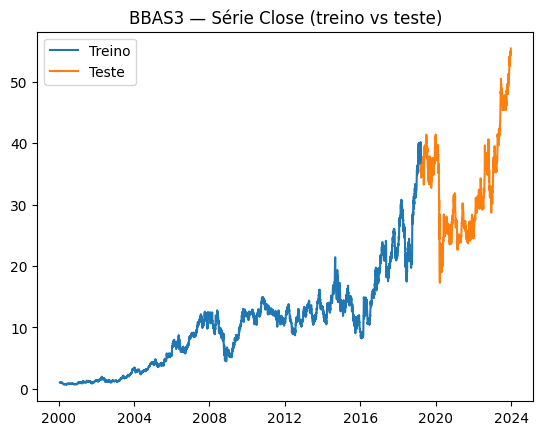

# CSNA3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.409986,1.588954,-1,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777,1.658908
1,2,2000-01-26,1.398052,1.569864,-1,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777
2,3,2000-01-27,1.375888,1.550466,-1,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139
3,4,2000-01-28,1.363953,1.531815,-1,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271
4,5,2000-01-31,1.329854,1.511619,-1,1.363953,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4744,2019-03-25,9.917939,9.592937,1,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488
1,4745,2019-03-26,10.543634,9.688007,1,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026
2,4746,2019-03-27,10.004474,9.719654,1,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350
3,4747,2019-03-28,10.437135,9.791402,1,10.004474,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440
4,4748,2019-03-29,10.816545,9.893916,1,10.437135,10.004474,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4743, 20) / (1186, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-03-22 00:00:00  
- **Período teste:** 2019-03-25 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2655, 1: 2088}  
**Treino (%):** {-1: 55.98, 1: 44.02}

**Teste:** {-1: 688, 1: 498}  
**Teste (%):** {-1: 58.01, 1: 41.99}

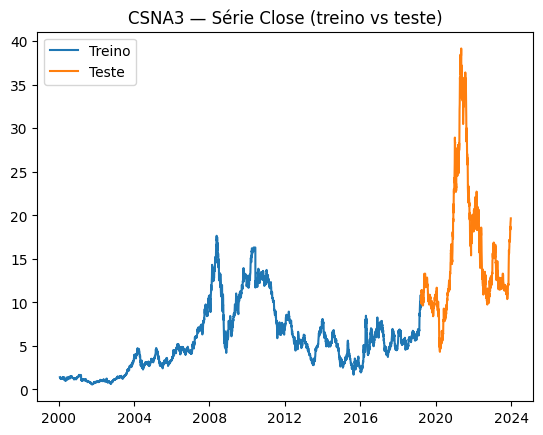

In [3]:

for ticker in CONFIG['FILES'].keys():
    df_tr, df_te = load_pair(ticker)
    parse_dates_inplace(df_tr)
    parse_dates_inplace(df_te)

    display(Markdown(f"# {ticker} — EDA"))
    display(Markdown("### treino.csv — head()"))
    display(df_tr.head())
    display(Markdown(f"**Colunas (treino):** {list(df_tr.columns)}"))
    display(Markdown("### teste.csv — head()"))
    display(df_te.head())
    display(Markdown(f"**Colunas (teste):** {list(df_te.columns)}"))

    dc = CONFIG['DATE_COL']
    tr_dates = (df_tr[dc].min(), df_tr[dc].max()) if dc in df_tr.columns else (None, None)
    te_dates = (df_te[dc].min(), df_te[dc].max()) if dc in df_te.columns else (None, None)
    display(Markdown(
        f"- **Tamanho treino/teste:** {df_tr.shape} / {df_te.shape}  \n"
        f"- **Período treino:** {tr_dates[0]} → {tr_dates[1]}  \n"
        f"- **Período teste:** {te_dates[0]} → {te_dates[1]}"
    ))

    ytr = df_tr[CONFIG['LABEL_COL']].astype(int)
    yte = df_te[CONFIG['LABEL_COL']].astype(int)
    ctr = ytr.value_counts().sort_index(); cte = yte.value_counts().sort_index()
    ptr = (ctr / ctr.sum() * 100).round(2); pte = (cte / cte.sum() * 100).round(2)
    display(Markdown("### Distribuição de rótulos"))
    display(Markdown(f"**Treino:** {ctr.to_dict()}  \n**Treino (%):** {ptr.to_dict()}"))
    display(Markdown(f"**Teste:** {cte.to_dict()}  \n**Teste (%):** {pte.to_dict()}"))

    cc = CONFIG['CLOSE_COL']
    if cc in df_tr.columns and cc in df_te.columns:
        fig, ax = plt.subplots()
        if dc in df_tr.columns:
            ax.plot(df_tr[dc], df_tr[cc], label="Treino")
        else:
            ax.plot(df_tr[cc].values, label="Treino")
        if dc in df_te.columns:
            ax.plot(df_te[dc], df_te[cc], label="Teste")
        else:
            ax.plot(df_te[cc].values, label="Teste")
        ax.set_title(f"{ticker} — Série Close (treino vs teste)")
        ax.legend()
        plt.show()



## Modelagem — MLP, CNN1D e LSTM


In [4]:

def build_mlp():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'],)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def build_cnn1d():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'], 1)),
        layers.Conv1D(32, kernel_size=3, padding="causal", activation="relu"),
        layers.Conv1D(32, kernel_size=5, padding="causal", activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def build_lstm():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'], 1)),
        layers.LSTM(32, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def tanh_to_pm1(pred):
    return np.where(pred.ravel() >= 0, 1, -1)

def eval_model(model, Xtr, ytr, Xte, yte, epochs=25, batch_size=64, verbose=0):
    hist = model.fit(Xtr, ytr, epochs=epochs, batch_size=batch_size, validation_data=(Xte, yte), verbose=verbose)
    yhat = model.predict(Xte, verbose=0)
    ypred = tanh_to_pm1(yhat)
    acc = accuracy_score(yte, ypred)
    cm  = confusion_matrix(yte, ypred, labels=[-1, 1])
    pr, rc, f1, _ = precision_recall_fscore_support(yte, ypred, labels=[1], average=None)
    return {"accuracy": acc, "precision_+1": pr[0], "recall_+1": rc[0], "f1_+1": f1[0], "cm": cm, "history": hist.history, "ypred": ypred}


In [5]:

# ================== EXECUÇÃO POR TICKER ==================
def run_all_models():
    all_results = []
    cms = {}
    ypred_store = {}  
    ytrue_store = {}  
    for ticker in CONFIG['FILES'].keys():
        df_tr, df_te = load_pair(ticker)
        Xtr, ytr = prepare_xy(df_tr); Xte, yte = prepare_xy(df_te)
        ytrue_store[ticker] = yte
        Xtr_s, Xte_s, Xtr_seq, Xte_seq = scale_and_reshape(Xtr, Xte)

        # MLP
        mlp = build_mlp()
        r_mlp = eval_model(mlp, Xtr_s, ytr, Xte_s, yte)
        all_results.append({"ticker": ticker, "model": "MLP", **{k:v for k,v in r_mlp.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"MLP")] = r_mlp["cm"]; ypred_store[(ticker,"MLP")] = r_mlp["ypred"]

        # CNN1D
        cnn = build_cnn1d()
        r_cnn = eval_model(cnn, Xtr_seq, ytr, Xte_seq, yte)
        all_results.append({"ticker": ticker, "model": "CNN1D", **{k:v for k,v in r_cnn.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"CNN1D")] = r_cnn["cm"]; ypred_store[(ticker,"CNN1D")] = r_cnn["ypred"]

        # LSTM
        lstm = build_lstm()
        r_lstm = eval_model(lstm, Xtr_seq, ytr, Xte_seq, yte)
        all_results.append({"ticker": ticker, "model": "LSTM", **{k:v for k,v in r_lstm.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"LSTM")] = r_lstm["cm"]; ypred_store[(ticker,"LSTM")] = r_lstm["ypred"]
    return all_results, cms, ypred_store, ytrue_store

all_results, cms, ypred_store, ytrue_store = run_all_models()

tbl = pd.DataFrame(all_results, columns=["ticker","model","accuracy","precision_+1","recall_+1","f1_+1"]) 
tbl.sort_values(["ticker","f1_+1","accuracy"], ascending=[True, False, False], inplace=True)
display(Markdown("### **Consolidado — Métricas por ativo/modelo**"))
display(tbl)

# ====== Métricas detalhadas por ativo/modelo ======
for (ticker, model), ypred in ypred_store.items():
    y_true = ytrue_store[ticker]
    acc = accuracy_score(y_true, ypred)
    cm = confusion_matrix(y_true, ypred, labels=[-1, 1])
    pre, rec, f1, sup = precision_recall_fscore_support(y_true, ypred, labels=[-1, 1], zero_division=0)
    report = classification_report(y_true, ypred, target_names=["SELL(-1)", "BUY(+1)"], digits=4, zero_division=0)

    display(Markdown(f"## {ticker} — {model}"))
    display(Markdown(f"**Acurácia (teste):** {acc:.4f}"))

    cm_df = pd.DataFrame(cm, index=["Verdade -1","Verdade +1"], columns=["Pred -1","Pred +1"]) 
    display(Markdown("**Matriz de confusão:**")); display(cm_df)

    pr_df = pd.DataFrame({
        "Classe": ["-1","+1"],
        "Precision": [pre[0], pre[1]],
        "Recall": [rec[0], rec[1]],
        "F1": [f1[0], f1[1]],
        "Suporte": [sup[0], sup[1]],
    })
    display(Markdown("**Precision/Recall/F1:**")); display(pr_df)

    display(Markdown("**Classification report (texto):**"))
    print(report)


### **Consolidado — Métricas por ativo/modelo**

,ticker,model,accuracy,precision_+1,recall_+1,f1_+1
6,BBAS3,MLP,0.794093,0.673077,0.987903,0.800654
7,BBAS3,CNN1D,0.819409,0.929878,0.614919,0.740291
8,BBAS3,LSTM,0.692827,0.616197,0.705645,0.657895
9,CSNA3,MLP,0.886172,0.815652,0.941767,0.874185
10,CSNA3,CNN1D,0.865093,0.797535,0.909639,0.849906
11,CSNA3,LSTM,0.789207,0.781818,0.690763,0.733475
3,PETR4,MLP,0.846218,0.796472,0.943730,0.863870
4,PETR4,CNN1D,0.846218,0.799726,0.937299,0.863064
5,PETR4,LSTM,0.627598,0.669261,0.553055,0.605634
0,VALE3,MLP,0.877805,0.867528,0.892027,0.879607


## VALE3 — MLP

**Acurácia (teste):** 0.8778

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,519,82
Verdade +1,65,537


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.888699,0.863561,0.875949,601
1,+1,0.867528,0.892027,0.879607,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.8887    0.8636    0.8759       601
     BUY(+1)     0.8675    0.8920    0.8796       602

    accuracy                         0.8778      1203
   macro avg     0.8781    0.8778    0.8778      1203
weighted avg     0.8781    0.8778    0.8778      1203



## VALE3 — CNN1D

**Acurácia (teste):** 0.8570

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,479,122
Verdade +1,50,552


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.905482,0.797005,0.847788,601
1,+1,0.818991,0.916944,0.865204,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9055    0.7970    0.8478       601
     BUY(+1)     0.8190    0.9169    0.8652       602

    accuracy                         0.8570      1203
   macro avg     0.8622    0.8570    0.8565      1203
weighted avg     0.8622    0.8570    0.8565      1203



## VALE3 — LSTM

**Acurácia (teste):** 0.6060

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,543,58
Verdade +1,416,186


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.566215,0.903494,0.696154,601
1,+1,0.762295,0.308970,0.439716,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.5662    0.9035    0.6962       601
     BUY(+1)     0.7623    0.3090    0.4397       602

    accuracy                         0.6060      1203
   macro avg     0.6643    0.6062    0.5679      1203
weighted avg     0.6643    0.6060    0.5678      1203



## PETR4 — MLP

**Acurácia (teste):** 0.8462

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,431,150
Verdade +1,35,587


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.924893,0.741824,0.823305,581
1,+1,0.796472,0.943730,0.863870,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9249    0.7418    0.8233       581
     BUY(+1)     0.7965    0.9437    0.8639       622

    accuracy                         0.8462      1203
   macro avg     0.8607    0.8428    0.8436      1203
weighted avg     0.8585    0.8462    0.8443      1203



## PETR4 — CNN1D

**Acurácia (teste):** 0.8462

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,435,146
Verdade +1,39,583


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.917722,0.748709,0.824645,581
1,+1,0.799726,0.937299,0.863064,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9177    0.7487    0.8246       581
     BUY(+1)     0.7997    0.9373    0.8631       622

    accuracy                         0.8462      1203
   macro avg     0.8587    0.8430    0.8439      1203
weighted avg     0.8567    0.8462    0.8445      1203



## PETR4 — LSTM

**Acurácia (teste):** 0.6276

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,411,170
Verdade +1,278,344


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.596517,0.707401,0.647244,581
1,+1,0.669261,0.553055,0.605634,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.5965    0.7074    0.6472       581
     BUY(+1)     0.6693    0.5531    0.6056       622

    accuracy                         0.6276      1203
   macro avg     0.6329    0.6302    0.6264      1203
weighted avg     0.6341    0.6276    0.6257      1203



## BBAS3 — MLP

**Acurácia (teste):** 0.7941

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,451,238
Verdade +1,6,490


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.986871,0.654572,0.787086,689
1,+1,0.673077,0.987903,0.800654,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9869    0.6546    0.7871       689
     BUY(+1)     0.6731    0.9879    0.8007       496

    accuracy                         0.7941      1185
   macro avg     0.8300    0.8212    0.7939      1185
weighted avg     0.8555    0.7941    0.7928      1185



## BBAS3 — CNN1D

**Acurácia (teste):** 0.8194

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,666,23
Verdade +1,191,305


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.777130,0.966618,0.861578,689
1,+1,0.929878,0.614919,0.740291,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.7771    0.9666    0.8616       689
     BUY(+1)     0.9299    0.6149    0.7403       496

    accuracy                         0.8194      1185
   macro avg     0.8535    0.7908    0.8009      1185
weighted avg     0.8411    0.8194    0.8108      1185



## BBAS3 — LSTM

**Acurácia (teste):** 0.6928

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,471,218
Verdade +1,146,350


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.763371,0.683599,0.721286,689
1,+1,0.616197,0.705645,0.657895,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.7634    0.6836    0.7213       689
     BUY(+1)     0.6162    0.7056    0.6579       496

    accuracy                         0.6928      1185
   macro avg     0.6898    0.6946    0.6896      1185
weighted avg     0.7018    0.6928    0.6948      1185



## CSNA3 — MLP

**Acurácia (teste):** 0.8862

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,582,106
Verdade +1,29,469


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.952537,0.845930,0.896074,688
1,+1,0.815652,0.941767,0.874185,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9525    0.8459    0.8961       688
     BUY(+1)     0.8157    0.9418    0.8742       498

    accuracy                         0.8862      1186
   macro avg     0.8841    0.8938    0.8851      1186
weighted avg     0.8951    0.8862    0.8869      1186



## CSNA3 — CNN1D

**Acurácia (teste):** 0.8651

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,573,115
Verdade +1,45,453


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.927184,0.832849,0.877489,688
1,+1,0.797535,0.909639,0.849906,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9272    0.8328    0.8775       688
     BUY(+1)     0.7975    0.9096    0.8499       498

    accuracy                         0.8651      1186
   macro avg     0.8624    0.8712    0.8637      1186
weighted avg     0.8727    0.8651    0.8659      1186



## CSNA3 — LSTM

**Acurácia (teste):** 0.7892

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,592,96
Verdade +1,154,344


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.793566,0.860465,0.825662,688
1,+1,0.781818,0.690763,0.733475,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.7936    0.8605    0.8257       688
     BUY(+1)     0.7818    0.6908    0.7335       498

    accuracy                         0.7892      1186
   macro avg     0.7877    0.7756    0.7796      1186
weighted avg     0.7886    0.7892    0.7870      1186



In [6]:
def highlight_max_custom(s):
    is_max = s == s.max()
    return ['background-color: #2ecc71; color: black; font-weight: bold;' if v else '' for v in is_max]

pivot = tbl.pivot(index="ticker", columns="model", values="accuracy")
display(Markdown("### Destaque por linha (maior accuracy)"))
display(pivot.style.apply(highlight_max_custom, axis=1))

### Destaque por linha (maior accuracy)

model,CNN1D,LSTM,MLP
ticker,,,
BBAS3,0.819409,0.692827,0.794093
CSNA3,0.865093,0.789207,0.886172
PETR4,0.846218,0.627598,0.846218
VALE3,0.857024,0.605985,0.877805



## Backtest 
Compara **Buy & Hold** vs. a **estratégia** 


### **VALE3**

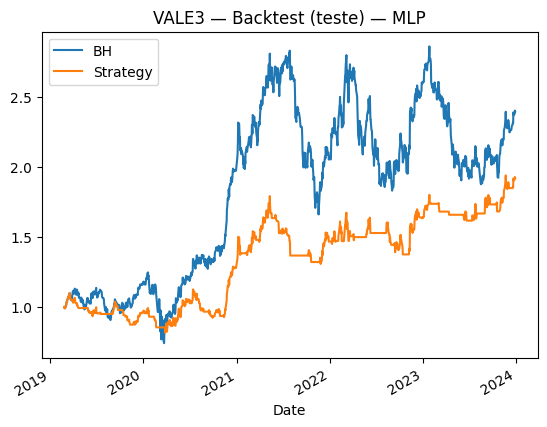

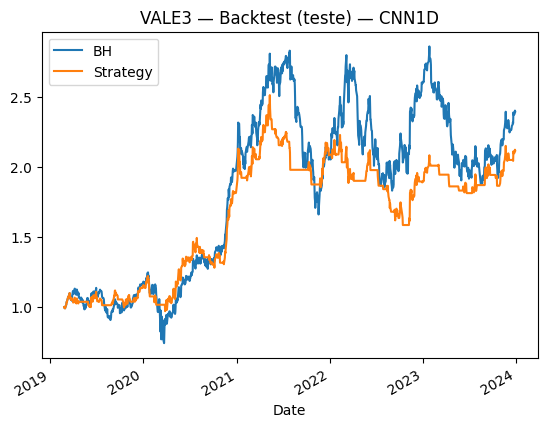

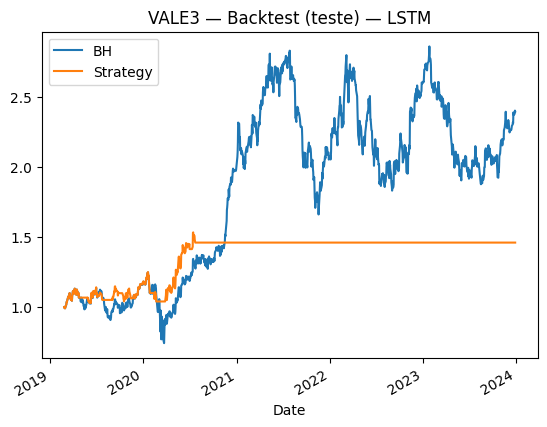

### **PETR4**

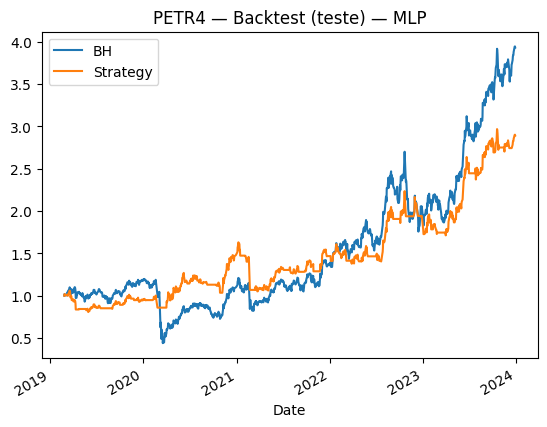

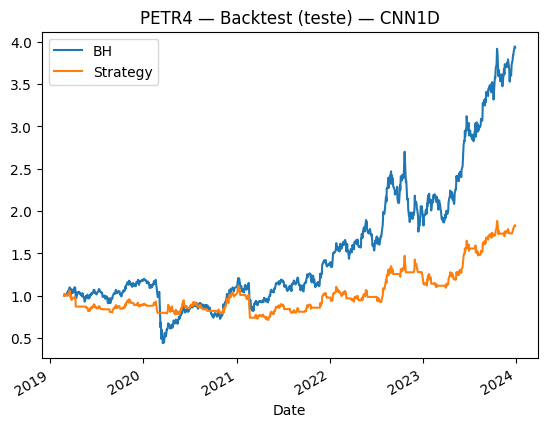

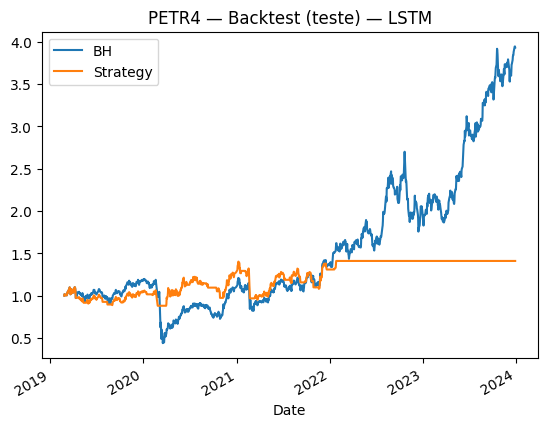

### **BBAS3**

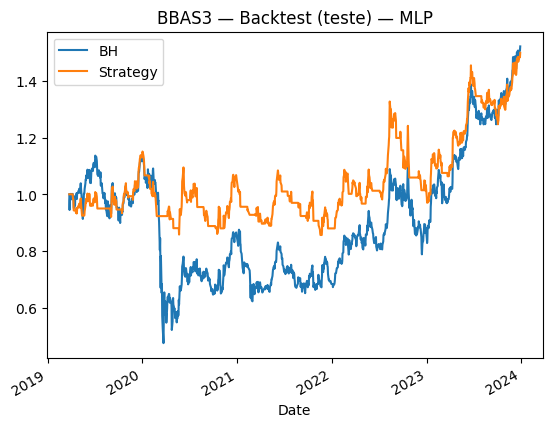

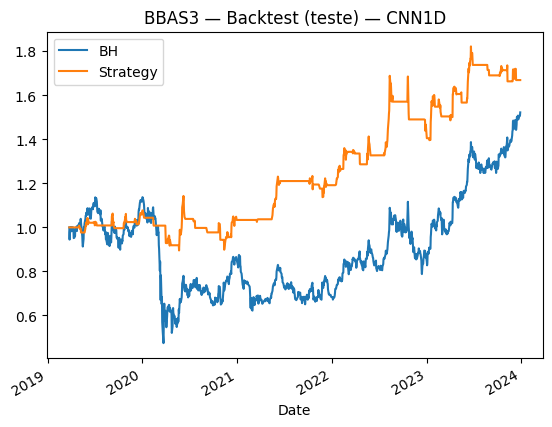

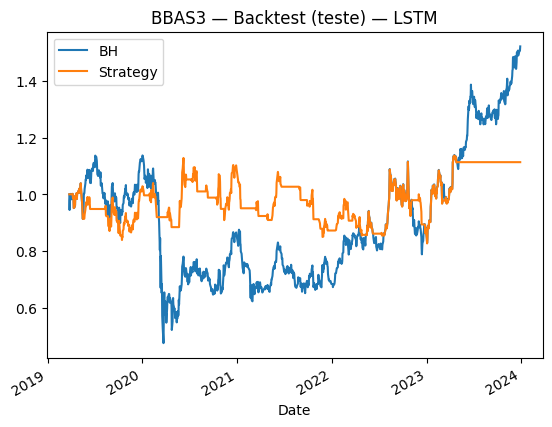

### **CSNA3**

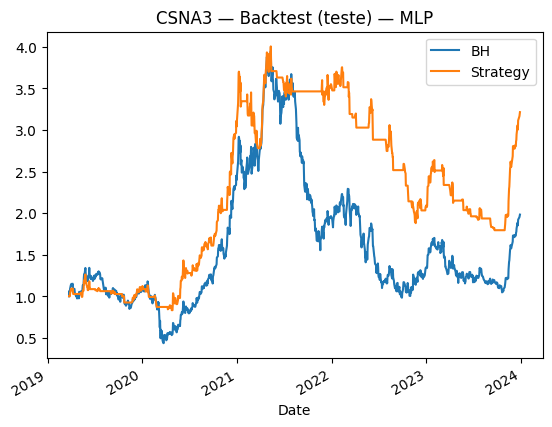

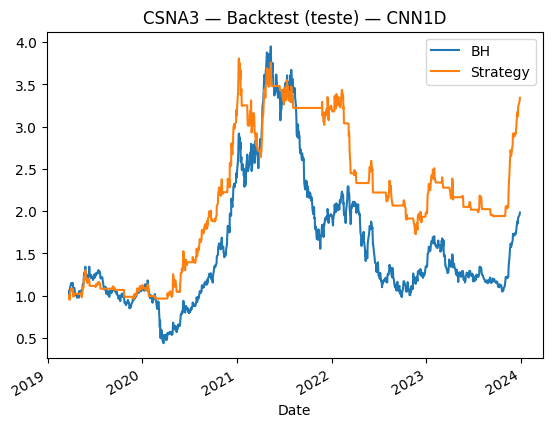

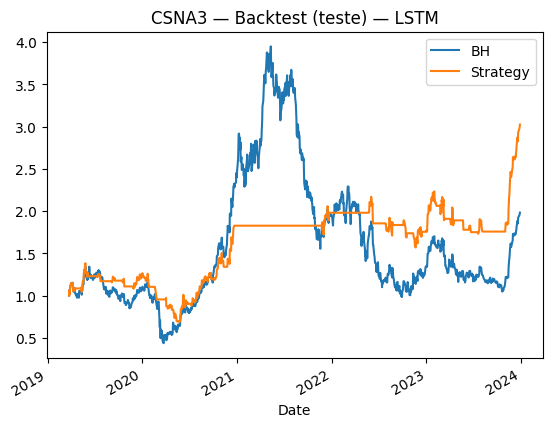

In [7]:

def backtest_equity_curve(df_test: pd.DataFrame, ypred_pm1: np.ndarray, date_col: str, close_col: str):
    # posição long/flat
    pos = (ypred_pm1 == 1).astype(int)
    close = df_test[close_col].astype(float).values
    ret = pd.Series(close).pct_change().fillna(0).values

    strat_eq = (1 + ret * pos).cumprod()
    bh_eq = (1 + ret).cumprod()

    if date_col in df_test.columns:
        idx = pd.to_datetime(df_test[date_col], errors='coerce')
    else:
        idx = pd.RangeIndex(len(df_test))

    return pd.DataFrame({"BH": bh_eq, "Strategy": strat_eq}, index=idx)

for ticker in CONFIG['FILES'].keys():
    display(Markdown(f"### **{ticker}**"))
    _, df_te = load_pair(ticker)
    for model in ["MLP","CNN1D","LSTM"]:
        eq = backtest_equity_curve(df_te, ypred_store[(ticker, model)], CONFIG['DATE_COL'], CONFIG['CLOSE_COL'])
        fig, ax = plt.subplots()
        eq.plot(ax=ax)
        ax.set_title(f"{ticker} — Backtest (teste) — {model}")
        plt.show()


# Análise das imagens  
Teste inicial com CSNA3

In [8]:
# ========= CNN 2D (comprar vs vender) =========
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)


TICKER = "CSNA3" 
ROOT   = Path("bases") / f"{TICKER}SA" / "imagens"
TRAIN_DIR, TEST_DIR = ROOT/"treino", ROOT/"teste"

IMG_SIZE = (128, 128)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='binary', seed=SEED)
ds_test  = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,  image_size=IMG_SIZE, batch_size=BATCH, label_mode='binary', seed=SEED)

class_names = ds_train.class_names  # ['comprar','vender']
normalizer  = keras.Sequential([layers.Rescaling(1/255.)])

ds_train = ds_train.map(lambda x,y: (normalizer(x), y), num_parallel_calls=AUTOTUNE).cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
ds_test  = ds_test.map(lambda x,y: (normalizer(x), y),  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

print("Classes:", class_names)


Found 4743 files belonging to 2 classes.
Found 1186 files belonging to 2 classes.
Classes: ['comprar', 'vender']


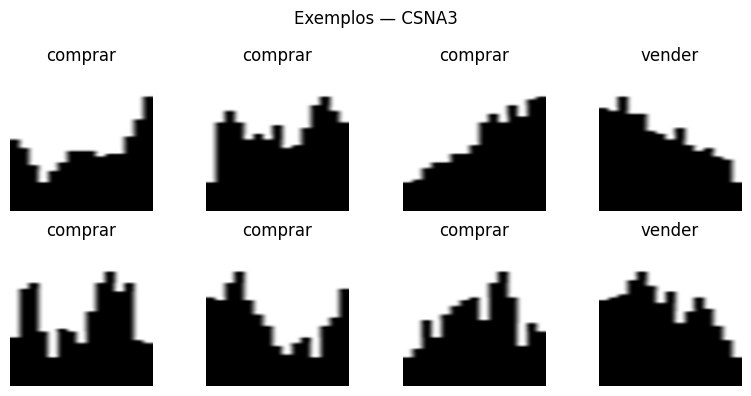

In [9]:

plt.figure(figsize=(8,4))
for i,(x,y) in enumerate(ds_train.unbatch().take(8)):
    plt.subplot(2,4,i+1)
    plt.imshow(x.numpy())
    plt.axis("off")
    plt.title(class_names[int(y.numpy())])
plt.suptitle(f"Exemplos — {TICKER}")
plt.tight_layout(); plt.show()


In [10]:
# --- CNN 2D  ---
model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE,3)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3, padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')   # binário: comprar(0)/vender(1)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 76s 478ms/step - accuracy: 0.7065 - loss: 0.5478 - precision: 0.6809 - recall: 0.8953 - val_accuracy: 0.8474 - val_loss: 0.3250 - val_precision: 0.8126 - val_recall: 0.9578
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.8712 - loss: 0.2898 - precision: 0.8862 - recall: 0.8832 - val_accuracy: 0.8423 - val_loss: 0.3693 - val_precision: 0.9808 - val_recall: 0.7427
Epoch 3/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.8769 - loss: 0.2821 - precision: 0.8927 - recall: 0.8866 - val_accuracy: 0.8786 - val_loss: 0.2770 - val_precision: 0.9401 - val_recall: 0.8445
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.8786 - loss: 0.2769 - precision: 0.8957 - recall: 0.8863 - val_accuracy: 0.8735 - val_loss: 0.2852 - val_precision: 0.9483 - val_recall: 0.8270
Epoch 5/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 251ms/step - accuracy: 0.8864 - loss: 0.2713 - precision: 0.9023 - recall: 0.8938 - val_accuracy: 0.8769

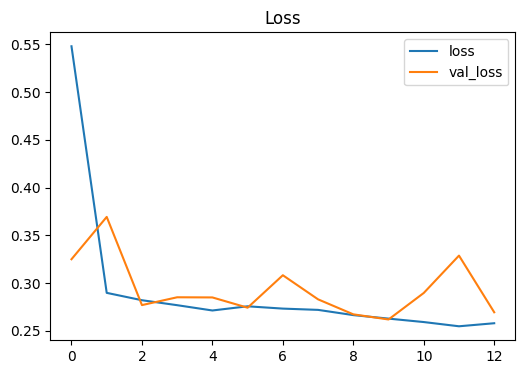

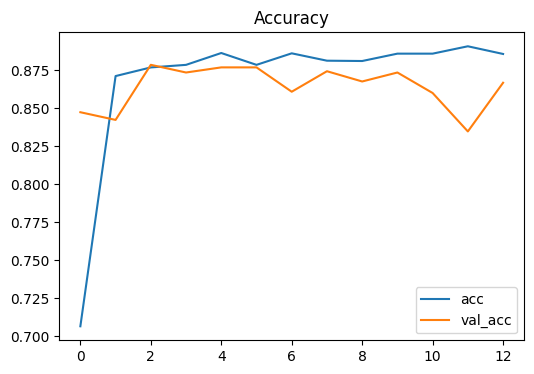

In [11]:
# --- treino básico com early stopping ---
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
history = model.fit(ds_train, validation_data=ds_test, epochs=15, callbacks=callbacks, verbose=1)

# curvas
h = history.history
plt.figure(figsize=(6,4)); plt.plot(h['loss'], label='loss'); plt.plot(h['val_loss'], label='val_loss'); plt.legend(); plt.title('Loss'); plt.show()
plt.figure(figsize=(6,4)); plt.plot(h['accuracy'], label='acc'); plt.plot(h['val_accuracy'], label='val_acc'); plt.legend(); plt.title('Accuracy'); plt.show()


Teste — Acc: 0.874  Precision: 0.922  Recall: 0.855  F1: 0.887

Relatório por classe (0 = comprar, 1 = vender):
              precision    recall  f1-score   support

     comprar       0.82      0.90      0.86       498
      vender       0.92      0.85      0.89       688

    accuracy                           0.87      1186
   macro avg       0.87      0.88      0.87      1186
weighted avg       0.88      0.87      0.87      1186



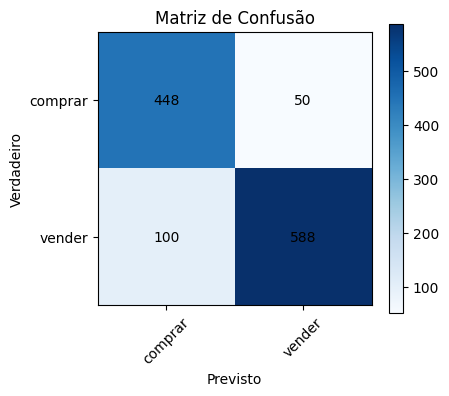

In [12]:
# --- avaliação no teste ---
# rótulos verdadeiros e probabilidades
y_true = np.concatenate([y.numpy().ravel() for _, y in ds_test])
y_prob = np.concatenate([model.predict(x, verbose=0).ravel() for x,_ in ds_test])
y_pred = (y_prob >= 0.5).astype(int)  # limiar simples de 0.5

acc = (y_pred == y_true).mean()
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

print(f"Teste — Acc: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")
print("\nRelatório por classe (0 = comprar, 1 = vender):")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# matriz de confusão
plt.figure(figsize=(4.6,4))
plt.imshow(cm, cmap='Blues'); plt.title('Matriz de Confusão'); plt.colorbar()
ticks = np.arange(len(class_names)); plt.xticks(ticks, class_names, rotation=45); plt.yticks(ticks, class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
plt.ylabel('Verdadeiro'); plt.xlabel('Previsto'); plt.tight_layout(); plt.show()


## Após primeiro teste, executando para as 4 ações

In [13]:
EPOCHS   = 15
VAL_SPLIT= 0.15

TICKERS = ["VALE3", "PETR4", "BBAS3", "CSNA3"]


def image_root_for(ticker: str) -> Path:
    return Path("bases") / f"{ticker}SA" / "imagens"


In [14]:
# ==== FUNÇÕES DE DADOS ====
def load_image_datasets(root: Path, img_size=IMG_SIZE, batch=BATCH, seed=SEED, val_split=VAL_SPLIT):
    train_dir = root/"treino"
    test_dir  = root/"teste"
    if not train_dir.exists() or not test_dir.exists():
        return None

    # treino + validação a partir do diretório de treino
    ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed, validation_split=val_split, subset='training'
    )
    ds_val = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed, validation_split=val_split, subset='validation'
    )
    ds_test = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,  image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed
    )

    class_names = ds_train.class_names  # ['comprar','vender']
    norm = keras.Sequential([layers.Rescaling(1/255.)])
    ds_train = ds_train.map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().shuffle(1000, seed=seed).prefetch(AUTOTUNE)
    ds_val   = ds_val  .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    ds_test  = ds_test .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    return ds_train, ds_val, ds_test, class_names

def count_by_class(split_dir: Path, classes):
    exts = {".png",".jpg",".jpeg",".bmp",".gif"}
    return {c: sum(1 for f in (split_dir/c).rglob("*") if f.suffix.lower() in exts) for c in classes}


In [15]:
# ==== MODELO ====
def build_cnn2d(img_size=IMG_SIZE):
    model = keras.Sequential([
        layers.Input(shape=(*img_size, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128,3, padding='same', activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])
    return model


In [16]:
# ==== TREINO + AVALIAÇÃO ====
def train_and_eval_for_ticker(ticker: str):
    root = image_root_for(ticker)
    ds = load_image_datasets(root)
    if ds is None:
        return {'ticker': ticker, 'status': 'sem_imagens'}

    ds_train, ds_val, ds_test, class_names = ds
    # pesos de classe (opcional, ajuda se desbalanceado)
    train_counts = count_by_class(root/"treino", class_names)
    tot = sum(train_counts.values())
    class_weight = {0: tot/(2*train_counts[class_names[0]]) if train_counts[class_names[0]] else 1.0,
                    1: tot/(2*train_counts[class_names[1]]) if train_counts[class_names[1]] else 1.0}

    model = build_cnn2d()
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
    history = model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS, callbacks=callbacks, class_weight=class_weight, verbose=0)

    # avaliação no TESTE
    y_true = np.concatenate([y.numpy().ravel() for _, y in ds_test])
    y_prob = np.concatenate([model.predict(x, verbose=0).ravel() for x,_ in ds_test])
    y_pred = (y_prob >= 0.5).astype(int)

    acc = (y_pred == y_true).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    # relatório por classe (string simples para o notebook)
    cls_report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

    return {
        'ticker': ticker,
        'status': 'ok',
        'class_names': class_names,
        'train_counts': train_counts,
        'metrics': {'acc': float(acc), 'precision': float(prec), 'recall': float(rec), 'f1': float(f1)},
        'cm': cm,
        'report': cls_report,
        'history': history.history
    }


=== VALE3 ===
Found 4808 files belonging to 2 classes.
Using 4087 files for training.
Found 4808 files belonging to 2 classes.
Using 721 files for validation.
Found 1203 files belonging to 2 classes.
Teste — Acc: 0.874  Precision: 0.875  Recall: 0.874  F1: 0.874
              precision    recall  f1-score   support

     comprar       0.87      0.88      0.87       602
      vender       0.88      0.87      0.87       601

    accuracy                           0.87      1203
   macro avg       0.87      0.87      0.87      1203
weighted avg       0.87      0.87      0.87      1203



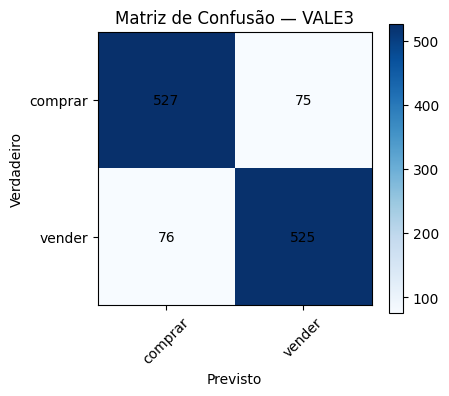

=== PETR4 ===
Found 4808 files belonging to 2 classes.
Using 4087 files for training.
Found 4808 files belonging to 2 classes.
Using 721 files for validation.
Found 1203 files belonging to 2 classes.
Teste — Acc: 0.860  Precision: 0.841  Recall: 0.876  F1: 0.858
              precision    recall  f1-score   support

     comprar       0.88      0.85      0.86       622
      vender       0.84      0.88      0.86       581

    accuracy                           0.86      1203
   macro avg       0.86      0.86      0.86      1203
weighted avg       0.86      0.86      0.86      1203



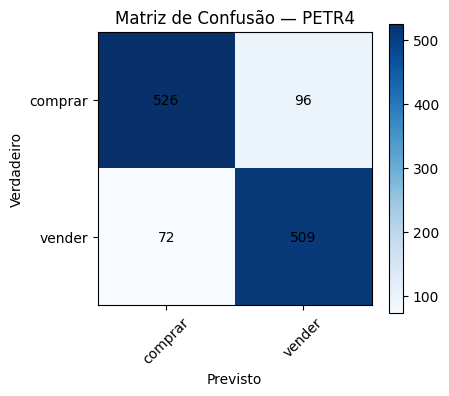

=== BBAS3 ===
Found 4735 files belonging to 2 classes.
Using 4025 files for training.
Found 4735 files belonging to 2 classes.
Using 710 files for validation.
Found 1185 files belonging to 2 classes.
Teste — Acc: 0.889  Precision: 0.906  Recall: 0.904  F1: 0.905
              precision    recall  f1-score   support

     comprar       0.87      0.87      0.87       496
      vender       0.91      0.90      0.90       689

    accuracy                           0.89      1185
   macro avg       0.89      0.89      0.89      1185
weighted avg       0.89      0.89      0.89      1185



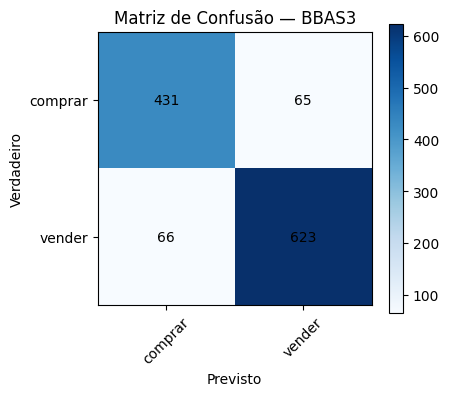

=== CSNA3 ===
Found 4743 files belonging to 2 classes.
Using 4032 files for training.
Found 4743 files belonging to 2 classes.
Using 711 files for validation.
Found 1186 files belonging to 2 classes.
Teste — Acc: 0.877  Precision: 0.911  Recall: 0.874  F1: 0.892
              precision    recall  f1-score   support

     comprar       0.83      0.88      0.86       498
      vender       0.91      0.87      0.89       688

    accuracy                           0.88      1186
   macro avg       0.87      0.88      0.87      1186
weighted avg       0.88      0.88      0.88      1186



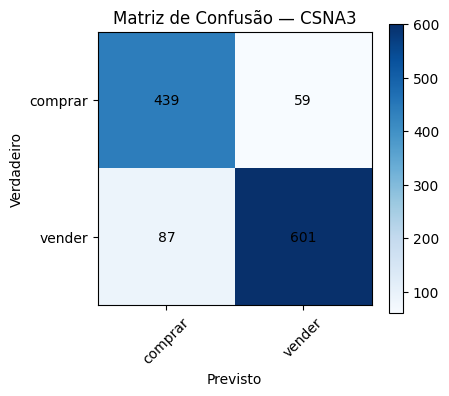

In [17]:
# ==== LOOP 
if 'results' not in globals():
    results = []
for t in TICKERS:
    print(f"=== {t} ===")
    out = train_and_eval_for_ticker(t)
    if out['status'] == 'ok':
        m = out['metrics']
        print(f"Teste — Acc: {m['acc']:.3f}  Precision: {m['precision']:.3f}  Recall: {m['recall']:.3f}  F1: {m['f1']:.3f}")
        print(out['report'])
        # plot da matriz de confusão
        cm = out['cm']; classes = out['class_names']
        plt.figure(figsize=(4.6,4))
        plt.imshow(cm, cmap='Blues'); plt.title(f'Matriz de Confusão — {t}'); plt.colorbar()
        ticks = np.arange(len(classes)); plt.xticks(ticks, classes, rotation=45); plt.yticks(ticks, classes)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
        plt.ylabel('Verdadeiro'); plt.xlabel('Previsto'); plt.tight_layout(); plt.show()

        results.append({'Ticker': t, 'Acc': m['acc'], 'Precision': m['precision'], 'Recall': m['recall'], 'F1': m['f1']})
    else:
        print("Pastas de imagens não encontradas — pulando.")
        results.append({'Ticker': t, 'Acc': np.nan, 'Precision': np.nan, 'Recall': np.nan, 'F1': np.nan})




In [18]:
df_res = pd.DataFrame(results).set_index('Ticker').round(3)
df_res

,Acc,Precision,Recall,F1
Ticker,,,,
VALE3,0.874,0.875,0.874,0.874
PETR4,0.860,0.841,0.876,0.858
BBAS3,0.889,0.906,0.904,0.905
CSNA3,0.877,0.911,0.874,0.892


In [19]:
# =========================
# TABELA COMPARATIVA FINAL
# (MLP, CNN1D, LSTM, CNN2D)
# =========================

_colmap = {
    # identificadores
    'ticker': 'ticker', 'Ticker': 'ticker', 'ativo': 'ticker',
    'model': 'model', 'modelo': 'model',
    # métricas padronizadas
    'accuracy': 'accuracy', 'acc': 'accuracy', 'Acc': 'accuracy',
    'precision': 'precision', 'Precision': 'precision', 'precisao': 'precision', 'precisão': 'precision',
    'recall': 'recall', 'Recall': 'recall', 'sensibilidade': 'recall',
    'f1': 'f1', 'F1': 'f1',
    # métricas com sufixo da classe positiva
    'precision_+1': 'precision', 'recall_+1': 'recall', 'f1_+1': 'f1',
}

def _normalize_any(rs):
    rows = []
    for r in rs:
        z = {}
        for k, v in r.items():
            key = _colmap.get(k, k)
            z[key] = v
        # Se veio do pipeline de imagens e não há 'model', rotula como CNN2D
        if 'model' not in z or z.get('model') in (None, ''):
            if any(k in z for k in ('accuracy','precision','recall','f1')):
                z['model'] = 'CNN2D'
        rows.append(z)
    return pd.DataFrame(rows)

# Junta o que existir no ambiente (tabular e/ou imagens)
_frames = []
if 'all_results' in globals():
    _frames.append(_normalize_any(all_results))
if 'results' in globals():
    _frames.append(_normalize_any(results))

df = pd.concat(_frames, ignore_index=True) if _frames else pd.DataFrame()

# Mantém só o que interessa (sem criar defaults; ausentes ficam fora)
wanted = ['ticker', 'model', 'accuracy', 'precision', 'recall', 'f1']
present = [c for c in wanted if c in df.columns]
df_metrics = df[present].copy()

# Ordenação didática dos modelos (apenas os presentes)
model_order = ['MLP','CNN1D','LSTM','CNN2D']
if 'model' in df_metrics.columns:
    present_models = [m for m in model_order if m in df_metrics['model'].dropna().unique()]
    df_metrics['model'] = pd.Categorical(df_metrics['model'], categories=present_models, ordered=True)

# Pivot: linhas = ativos, colunas multinível = métricas × modelo
if set(['ticker','model']).issubset(df_metrics.columns):
    pivot = df_metrics.pivot_table(index='ticker', columns='model', values=[c for c in ['accuracy','precision','recall','f1'] if c in df_metrics.columns], aggfunc='mean')
else:
    pivot = pd.DataFrame()

# Médias por modelo (entre ativos)
if 'model' in df_metrics.columns:
    metrics_cols = [c for c in ['accuracy','precision','recall','f1'] if c in df_metrics.columns]
    means_by_model = df_metrics.groupby('model')[metrics_cols].mean()
else:
    means_by_model = pd.DataFrame()

# Formatação: vazio quando NaN
def _fmt(df_):
    return df_.applymap(lambda x: f"{x:.3f}" if pd.notnull(x) else "")

display(Markdown("### 📊 Comparativo por Ativo × Modelo"))
display(_fmt(pivot) if not pivot.empty else Markdown("Sem dados para montar a tabela."))

display(Markdown("### 🧮 Média por Modelo (entre ativos)"))

if not means_by_model.empty:

    means_T = means_by_model.T

    def _highlight_max_row(s):
        m = s.max(skipna=True)
        return ['background-color: #2ecc71; color: black; font-weight: bold;' if (pd.notnull(v) and v == m) else '' for v in s]

    styler = (
        means_T
        .style
        .apply(_highlight_max_row, axis=1)   
        .format("{:.3f}", na_rep="")         
    )
    display(styler)
else:
    display(Markdown("Sem dados para calcular as médias."))

### 📊 Comparativo por Ativo × Modelo

accuracy                          f1                      precision  \
model       MLP  CNN1D   LSTM  CNN2D    MLP  CNN1D   LSTM  CNN2D       MLP   
ticker                                                                       
BBAS3     0.794  0.819  0.693  0.889  0.801  0.740  0.658  0.905     0.673   
CSNA3     0.886  0.865  0.789  0.877  0.874  0.850  0.733  0.892     0.816   
PETR4     0.846  0.846  0.628  0.860  0.864  0.863  0.606  0.858     0.796   
VALE3     0.878  0.857  0.606  0.874  0.880  0.865  0.440  0.874     0.868   

                            recall                       
model   CNN1D   LSTM  CNN2D    MLP  CNN1D   LSTM  CNN2D  
ticker                                                   
BBAS3   0.930  0.616  0.906  0.988  0.615  0.706  0.904  
CSNA3   0.798  0.782  0.911  0.942  0.910  0.691  0.874  
PETR4   0.800  0.669  0.841  0.944  0.937  0.553  0.876  
VALE3   0.819  0.762  0.875  0.892  0.917  0.309  0.874

### 🧮 Média por Modelo (entre ativos)

model,MLP,CNN1D,LSTM,CNN2D
accuracy,0.851,0.847,0.679,0.875
precision,0.788,0.837,0.707,0.883
recall,0.941,0.845,0.565,0.882
f1,0.855,0.830,0.609,0.882


O MLP apresenta alto recall, mas baixa precisão, o que sugere tendência a favorecer a classe majoritária.  
Já a CNN2D se destaca como o modelo mais equilibrado, com as melhores médias em acurácia, precisão e f1-score, cumprindo melhor o papel de perseguidor de tendência.